In [26]:
from astroquery.gaia import Gaia
from astropy import units as u
from astropy import wcs
from astropy.constants import h, c
from astropy import convolution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy import signal
import re
import os
from glob import glob
from PIL import Image

In [27]:
# Constants
fd_unit = u.J/u.m**2/u.s/u.nm
d_filters = {'Band':['G','BP','RP'],'Wavelength':[639.07*u.nm,518.26*u.nm,782.51*u.nm],'Bandpass':[454.82*u.nm,265.9*u.nm,292.75*u.nm],'clam':[1.346e-21*fd_unit,3.009e-21*fd_unit,1.638e-21*fd_unit]} 
filters = pd.DataFrame(data=d_filters)
qe = pd.read_csv('./ccd_data/QE.csv',delimiter=',')
dark = pd.read_csv('./ccd_data/dark_current.csv',delimiter=',')

ccd_width_px = 4656
ccd_height_px = 3520
ccd_width_buff_px = 512
ccd_height_buff_px = 512
ccd_px_side_length_micron = 3.8 * u.micron
ccd_width_micron = ccd_width_px * ccd_px_side_length_micron
ccd_height_micron = ccd_height_px * ccd_px_side_length_micron
ccd_width_buff_micron = ccd_width_buff_px * ccd_px_side_length_micron
ccd_height_buff_micron = ccd_height_buff_px * ccd_px_side_length_micron
plate_scale_arcsec_micron = 0.11 * u.arcsec/u.micron
plate_scale_arcsec_px = plate_scale_arcsec_micron * ccd_px_side_length_micron
ccd_width_range_arcsec = ccd_width_micron * plate_scale_arcsec_micron
ccd_height_range_arcsec = ccd_height_micron * plate_scale_arcsec_micron
ccd_width_buff_range_arcsec = ccd_width_buff_micron * plate_scale_arcsec_micron
ccd_height_buff_range_arcsec = ccd_height_buff_micron * plate_scale_arcsec_micron
ccd_width_range_deg = ccd_width_range_arcsec.to(u.deg)
ccd_height_range_deg = ccd_height_range_arcsec.to(u.deg)
ccd_width_buff_range_deg = ccd_width_buff_range_arcsec.to(u.deg)
ccd_height_buff_range_deg = ccd_height_buff_range_arcsec.to(u.deg)
mast_collecting_area_m2 = 0.09 * np.pi * u.m**2
gaia_collecting_area_m2 = 0.7 * u.m**2
ccd_full_well = 20000 * u.electron
gaia_mast_attenuation = 0.5

fov_right_from_fiffa = 0.18 * u.deg
fov_left_from_fiffa = 0.146 * u.deg
fiffa_left_px = int(np.ceil(fov_left_from_fiffa / plate_scale_arcsec_px.to(u.deg)))
fiffa_right_px = int(ccd_width_px - np.floor(fov_right_from_fiffa / plate_scale_arcsec_px.to(u.deg)) - 1)
fiffa_height = (17 * u.mm).to(u.micron)
fiffa_length = (4.6 * u.mm).to(u.micron)
fiffa_ang = 45 * u.deg
mast_diameter = 0.6 * u.m
mast_focal_length = 1.8 * u.m
incoming_light_fov = np.arctan(mast_diameter/mast_focal_length)

rms_vs_field = np.loadtxt('./RMSvsField_text.txt',dtype=float,skiprows=13,encoding='utf-16-le')
field_arr_deg = rms_vs_field[:,0]
field_arr_px = np.floor(field_arr_deg/plate_scale_arcsec_px.to(u.deg).value)
rms_arr_px = rms_vs_field[:,1]/ccd_px_side_length_micron.value 
field_arr_deg= np.hstack((-np.flip(field_arr_deg[1:]),field_arr_deg))
field_arr_px = np.hstack((-np.flip(field_arr_px[1:]),field_arr_px))
field_arr_px += int(ccd_width_px/2) - 1 
rms_arr_px = np.hstack((np.flip(rms_arr_px[1:]),rms_arr_px))

r_lst = [0, 388, 776, 1164, 1552, 1940, 2328]
ang0 = 90

In [9]:
ra_widget = widgets.BoundedFloatText(
    value=279.3643447,
    min=0,
    max=360,
    step=0.001,
    description='RA:'
)
dec_widget = widgets.BoundedFloatText(
    value=38.79739118,
    min=-90,
    max=90,
    step=0.001,
    description='DEC:'
)
max_mag_widget = widgets.FloatText(
    value=18,
    step=0.01,
    description='Max Mag:'
)
display(ra_widget)
display(dec_widget)
display(max_mag_widget)

BoundedFloatText(value=279.3643447, description='RA:', max=360.0, step=0.001)

BoundedFloatText(value=38.79739118, description='DEC:', max=90.0, min=-90.0, step=0.001)

FloatText(value=18.0, description='Max Mag:', step=0.01)

In [19]:
def get_entries(max_mag, ra, dec, ccd_width_range_deg, ccd_height_range_deg):
    query = '''SELECT SOURCE_ID, RA, DEC, PHOT_G_MEAN_MAG, HAS_XP_SAMPLED,
    PHOT_G_MEAN_FLUX AS PHOT_G_MEAN_FLUX_GAIA, PHOT_G_MEAN_FLUX_ERROR AS PHOT_G_MEAN_FLUX_ERROR_GAIA,
    PHOT_BP_MEAN_FLUX AS PHOT_BP_MEAN_FLUX_GAIA, PHOT_BP_MEAN_FLUX_ERROR AS PHOT_BP_MEAN_FLUX_ERROR_GAIA,
    PHOT_RP_MEAN_FLUX AS PHOT_RP_MEAN_FLUX_GAIA, PHOT_RP_MEAN_FLUX_ERROR AS PHOT_RP_MEAN_FLUX_ERROR_GAIA
    FROM gaiadr3.gaia_source
    WHERE (ra BETWEEN {ra_min} AND {ra_max})
    AND (dec BETWEEN {dec_min} AND {dec_max})
    AND phot_g_mean_mag < {max_mag}
    ORDER BY PHOT_G_MEAN_MAG
    '''.format(
        max_mag=max_mag,
        ra_min=ra-(ccd_width_range_deg.value/2), ra_max=ra+(ccd_width_range_deg.value/2),
        dec_min=dec-(ccd_height_range_deg.value/2), dec_max=dec+(ccd_height_range_deg.value/2)
    )
    job = Gaia.launch_job(query)
    r = job.get_results()
    return r

def convert_to_flux_density(table):
    # gets flux mean, flux error in electrons/sec (as given in GAIA_SOURCE) and name of band {'G','BP,'RP'}
    # returns flux density + uncertainty in watt/m^2/nm
    for filter in d_filters['Band']:
        table['flux_' + filter + '_density_gaia'] = filters[filters['Band'] == filter]['clam'].iloc[0] * table['phot_' + str.lower(filter) + '_mean_flux_gaia'].value # convert to incoming flux density
        table['flux_' + filter + '_density_error_gaia'] =  filters[filters['Band'] == filter]['clam'].iloc[0] * table['phot_' + str.lower(filter) + '_mean_flux_error_gaia'].value

def get_flux_from_spectrum(table):
    lam0 = filters[filters.Band == 'G'].iloc[0]['Wavelength']
    bandpass = filters[filters.Band == 'G'].iloc[0]['Bandpass']
    lmin = lam0 - bandpass/2
    lmax = lam0 + bandpass/2
    source_ids = table['source_id'][table['has_xp_sampled']==True]
    datalink = Gaia.load_data(ids=source_ids, data_release = 'Gaia DR3', retrieval_type='XP_SAMPLED', data_structure = 'INDIVIDUAL', verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()
    for dl_key in dl_keys:
        t = datalink[dl_key][0]
        source_id = t.get_field_by_id('source_id').value
        t = t.to_table()
        y1arr = qe['QE'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)]
        y2arr = np.ma.getdata(t['flux'].value)[int((lmin.value-336)/2):int((lmax.value-336)/2)]
        xarr = qe['Wavelength'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)]
        fmast = np.trapz(y1arr*y2arr*xarr*1e-9/h.value/c.value,xarr)*gaia_mast_attenuation*mast_collecting_area_m2/u.m**2
        table['phot_G_flux_mast'][table['source_id'] == source_id] = fmast

def convert_gaia_to_mast(table):
    for filter in d_filters['Band']:
        lam0 = filters[filters.Band == filter].iloc[0]['Wavelength']
        bandpass = filters[filters.Band == filter].iloc[0]['Bandpass']
        flux_density_inc_mast =  gaia_mast_attenuation * table['flux_' + filter + '_density_gaia']
        flux_meas_mast = effective_qe(lam0-bandpass/2,lam0+bandpass/2)* flux_density_inc_mast * bandpass
        power_meas_mast = flux_meas_mast * mast_collecting_area_m2
        table['phot_' + filter + '_flux_mast'] = (power_meas_mast * lam0.to(u.m) / (h * c)) * u.electron 

        flux_density_inc_error_mast =  gaia_mast_attenuation * table['flux_' + filter + '_density_error_gaia']
        flux_meas_error_mast = effective_qe(lam0-bandpass/2,lam0+bandpass/2) * flux_density_inc_error_mast * bandpass
        power_meas_error_mast = flux_meas_error_mast * mast_collecting_area_m2
        table['phot_' + filter + '_flux_rel_error_mast'] = np.sqrt(((power_meas_error_mast * lam0.to(u.m) / (h * c)).value)**2 + ((power_meas_mast * bandpass.to(u.m) / (2 * h * c)).value)**2) / table['phot_' + filter + '_flux_mast'].value * 100 * u.percent

def effective_qe(lmin,lmax):
    return np.mean(qe['QE'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)])

def px_spread(w_px,h_px,side):
    wmin = int(np.max([int(w_px-side),0]))
    wmax = int(np.min([int(w_px+side),ccd_width_px]))
    hmin = int(np.max([int(h_px-side),0]))
    hmax = int(np.min([int(h_px+side),ccd_height_px]))
    return wmin,wmax,hmin,hmax

def four_px(w_px,h_px,wid,hei):
    lst = []
    if (w_px <0 or w_px >= wid or h_px < 0 or h_px >= hei):
        return lst
    wf = np.floor(w_px)
    wc = np.ceil(w_px)
    hf = np.floor(h_px)
    hc = np.ceil(h_px)
    if np.allclose(w_px,wf): 
        w_floor_res = 1
        w_ceil_res = 0
    else: 
        w_floor_res = np.round(w_px - wf,3)
        w_ceil_res = np.round(wc - w_px,3)
    if np.allclose(h_px,hf): 
        h_floor_res = 1
        h_ceil_res = 0
    else: 
        h_floor_res = np.round(h_px - hf,3)
        h_ceil_res = np.round(hc - h_px,3)    

    if (wf >= 0 and hf >= 0):
        lst.append([wf ,hf ,w_floor_res*h_floor_res])
    if (wc < wid and hf >= 0):
        lst.append([wc ,hf ,w_ceil_res*h_floor_res])
    if (wf >= 0 and hc < hei):
        lst.append([wf ,hc ,w_floor_res*h_ceil_res])
    if (wc < wid and hc < hei):
        lst.append([wc , hc ,w_ceil_res*h_ceil_res])
    return lst

def rot(psf,ang,ang0):
    im = Image.fromarray(psf)
    im = im.rotate(ang0-ang)
    im = np.array(im)
    im = im/np.sum(im)
    return im
        
def add_sources(image,table,wcs_dict,t_exp):
    pixs = wcs_dict.wcs_world2pix(table['ra'].value, table['dec'].value, 0)
    flux = np.round(table['phot_G_flux_mast'].value)
    brightness = np.random.poisson(lam = flux) * t_exp / u.s 
    for i in range(len(pixs[0])):
        # wmin,wmax,hmin,hmax = px_spread(pixs[0][i],pixs[1][i],20)
        # image[hmin:hmax,wmin:wmax] = brightness[i] # for now, brightness = number of photo electrons 
        lst = four_px(pixs[0][i],pixs[1][i],image.shape[1],image.shape[0])
        for ls in lst:
            image[int(ls[1]),int(ls[0])] += ls[2] * brightness[i]
            if(ccd_width_buff_px/2 < int(ls[0]) < (ccd_width_px + ccd_width_buff_px/2) and ccd_height_buff_px/2 < int(ls[1]) < (ccd_height_px + ccd_height_buff_px/2)):
                add_coma(image,int(ls[0]),int(ls[1]))
    return image

def add_seeing(image,seeing_arcsec):
    seeing_px = seeing_arcsec / plate_scale_arcsec_micron / ccd_px_side_length_micron
    sigma = seeing_px/2.355 # fhwm = 2*sqrt(2*ln(2))*sigma
    ker = convolution.Gaussian2DKernel(x_stddev = sigma , y_stddev = sigma)
    return convolution.convolve(image,ker)

def add_bgd_noise(image,mag_arcsec_squared,t_exp):
    rate = 2e5*u.electron/u.s/u.arcsec**2*10**(-0.4*(mag_arcsec_squared-10))*(plate_scale_arcsec_px)**2
    mean = (rate * t_exp).value
    image += np.random.normal(loc = mean, scale = np.sqrt(mean), size = (image.shape[0],image.shape[1])) # for now, brightness = number of photo electrons 
    return image

def fiffa_shadow_at_col(w_arr):     
    fiffa_left_y = fiffa_height + fiffa_length/2 * np.sin(np.deg2rad(fiffa_ang.value))
    fiffa_right_y = fiffa_height - fiffa_length/2 * np.sin(np.deg2rad(fiffa_ang.value))
    ccd_dead_left_px = int(fiffa_left_px + fiffa_left_y / ccd_px_side_length_micron * np.tan(incoming_light_fov/2))
    ccd_live_left_px = int(fiffa_left_px - fiffa_left_y / ccd_px_side_length_micron * np.tan(incoming_light_fov/2))
    ccd_dead_right_px = int(fiffa_right_px - fiffa_right_y / ccd_px_side_length_micron  * np.tan(incoming_light_fov/2))
    ccd_live_right_px = int(fiffa_right_px + fiffa_right_y / ccd_px_side_length_micron  * np.tan(incoming_light_fov/2))
        
    open_fov = np.ones(len(w_arr))

    for i,w in enumerate(w_arr):
        if(ccd_live_left_px <= w <= ccd_dead_left_px):
            x_left = w 
            left_open_edge_px =  x_left - fiffa_left_y / ccd_px_side_length_micron * np.tan(incoming_light_fov/2)
            left_open_fov = np.arcsin((fiffa_left_px-left_open_edge_px)/np.sqrt((x_left-fiffa_left_px)**2 + (fiffa_left_y/ccd_px_side_length_micron)**2)*np.cos(incoming_light_fov/2))
            open_fov[i] = left_open_fov / incoming_light_fov

        elif(ccd_dead_right_px <= w <= ccd_live_right_px):
            x_right = w   
            right_open_edge_px =  x_right + fiffa_right_y / ccd_px_side_length_micron * np.tan(incoming_light_fov/2)
            right_open_fov = np.arcsin((right_open_edge_px - fiffa_right_px)/np.sqrt((x_right-fiffa_right_px)**2 + (fiffa_right_y/ccd_px_side_length_micron)**2)*np.cos(incoming_light_fov/2))
            open_fov[i] = right_open_fov / incoming_light_fov

        elif(ccd_dead_left_px < w < ccd_dead_right_px):
            open_fov[i] = 0

    return open_fov

def snr_vs_field(magnitudes, read_rms, t_exp = 1*u.s, seeing_arcsec = 1.5*u.arcsec ,mag_arcsec_squared = 20.5 , temp = -15):
    N_source = 2e5 * 10**(-0.4*(magnitudes - 10)) * t_exp.value # rough estimate of electron flux from source of known magnitude
    fiffa_shadow = fiffa_shadow_at_col(field_arr_px)

    n_pix = 1 + (rms_arr_px * seeing_arcsec / plate_scale_arcsec_px)**2 # rough estimate of total pixel number in the PSF

    N_bgd = 2e5 * 10**(-0.4*(mag_arcsec_squared - 10)) * (plate_scale_arcsec_px.value)**2 * t_exp.value
    dark_rate = dark[dark.temp == temp].iloc[0]['e/s/pix'] * u.electron/u.s
    N_dark = (dark_rate * t_exp).value 
    N_read = read_rms.value
    SNR = np.zeros((len(N_source),len(field_arr_px)))

    fig,ax = plt.subplots(figsize=(5,5),dpi=120)
    ax.set_xlabel('Field (deg)', fontdict={'size': 12})
    ax.set_ylabel('SNR', fontdict={'size': 12})
    for i,ns in enumerate(N_source):
        ns_detected = ns * fiffa_shadow
        SNR[i] = ns_detected/np.sqrt(ns_detected + n_pix*(N_bgd*fiffa_shadow + N_dark + N_read**2))
        ax.plot(field_arr_deg,SNR[i],label=f'mag={magnitudes[i]}')    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join((
    r'$t_{exp}=%d s$' % (t_exp.value, ),
    r'$sky=%.1f \frac{mag}{arcsec^2}$' % (mag_arcsec_squared, ),
    r'$seeing=%.2f arcsec$' % (seeing_arcsec.value, ),
    r'$read rms=%.1f \frac{e^-}{px}$' % (read_rms.value, )))
    ax.text(1.02, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    ax.legend(loc=[1.01,0.5])
    ax.grid()
    fig.show()

def remove_dead(image):
    columns = np.arange(0,ccd_width_px,1)
    fiffa_shadow = np.diag(fiffa_shadow_at_col(columns))
    image = image @ fiffa_shadow
    return image

def add_read_dark_noise(image,temperature,read_rms,t_exp):
    dark_rate = dark[dark.temp == temperature].iloc[0]['e/s/pix'] * u.electron/u.s
    mean = (dark_rate * t_exp).value
    var = (dark_rate * t_exp).value + read_rms.value**2
    image += np.random.normal(loc = mean, scale = np.sqrt(var), size = (image.shape[0],image.shape[1])) # for now, brightness = number of photo electrons 
    return image

def add_coma(image,w,h):    
    wc = int(ccd_width_buff_px/2) + int(ccd_width_px/2) - 1
    hc = int(ccd_height_buff_px/2) + int(ccd_height_px/2) - 1
    dis_from_center = np.sqrt((w-wc)**2 + (h-hc)**2)
    ang = np.rad2deg(np.arctan2(h-hc,w-wc))
    r_ker = r_lst[np.argmin(np.abs(r_lst - dis_from_center))]
    ker_name = os.path.join('.', 'kernels_rings', str.format(r'r={}.npy',r_ker))
    ker = np.load(ker_name)
    ker = rot(ker,ang,ang0)
    size = ker.shape
    w_start = w - int(size[1]/2)
    h_start = h - int(size[0]/2)
    w_finish = w_start + size[1]
    h_finish = h_start + size[0]
    image[h_start:h_finish,w_start:w_finish] += image[h,w] * ker
    return image
            

def convolve_region_based_kernel(img, kernel_folder, img_row_lower_lim, img_col_lower_lim, conv_img_row, conv_img_col):
    img_conv = np.zeros((conv_img_row, conv_img_col))
    for kernel_file_path in glob(os.path.join(kernel_folder, '*')):
        kernel = np.load(kernel_file_path)
        k_rows, k_cols = kernel.shape
        px_match = re.search('(\d+):(\d+)X(\d+):(\d+)', kernel_file_path)
        patch_rel_row_start = int(px_match.group(1))
        patch_rel_row_end = int(px_match.group(2))
        patch_rel_col_start = int(px_match.group(3))
        patch_rel_col_end = int(px_match.group(4))
        patch_row_start = img_row_lower_lim+patch_rel_row_start-k_rows+1
        patch_row_end = img_row_lower_lim+patch_rel_row_end+1
        patch_col_start = img_col_lower_lim+patch_rel_col_start-k_cols+1
        patch_col_end = img_col_lower_lim+patch_rel_col_end+1
        patch = img[patch_row_start:patch_row_end,patch_col_start:patch_col_end]
        patch_conv = signal.convolve2d(patch, kernel, mode='valid')
        img_conv[patch_rel_row_start:patch_rel_row_end+1,patch_rel_col_start:patch_rel_col_end+1] = patch_conv
    return img_conv

def create_table(max_mag, ra_center, dec_center, use_available_spectra=False):
    coor_width_range_deg = (ccd_width_range_deg + ccd_width_buff_range_deg) / np.cos(np.deg2rad(dec_center))
    coor_height_range_deg = ccd_height_range_deg + ccd_height_buff_range_deg
    entries = get_entries(max_mag, ra_center, dec_center, coor_width_range_deg, coor_height_range_deg)
    convert_to_flux_density(entries)
    convert_gaia_to_mast(entries)
    if(use_available_spectra):
        get_flux_from_spectrum(entries)
    return entries

def create_image(table, ra_center , dec_center, t_exp = 1*u.s,seeing_arcsec = 1.5*u.arcsec ,mag_arcsec_squared = 20.5 , temp = -15):
    wcs_input_dict = {
    'CTYPE1': 'RA---TAN', 
    'CUNIT1': 'deg', 
    'CDELT1': (plate_scale_arcsec_px.to(u.deg)).value, 
    'CRPIX1': (ccd_width_px+ccd_width_buff_px)/2 - 1, 
    'CRVAL1': ra_center, 
    'NAXIS1': ccd_width_px+ccd_width_buff_px,
    'CTYPE2': 'DEC--TAN', 
    'CUNIT2': 'deg', 
    'CDELT2': (plate_scale_arcsec_px.to(u.deg)).value, 
    'CRPIX2': (ccd_height_px+ccd_height_buff_px)/2 - 1, 
    'CRVAL2': dec_center, 
    'NAXIS2': ccd_height_px+ccd_height_buff_px
    }
    wcs_dict = wcs.WCS(wcs_input_dict)
    image = np.zeros((ccd_height_px + ccd_height_buff_px, ccd_width_px + ccd_width_buff_px))
    image = add_sources(image,table,wcs_dict,t_exp)
    image = add_bgd_noise(image,mag_arcsec_squared,t_exp)
    image = add_seeing(image,seeing_arcsec)
    # image = convolve_region_based_kernel(image, r'./kernels', int(ccd_height_buff_px/2), int(ccd_width_buff_px/2), ccd_height_px, ccd_width_px)
    image = image[int(ccd_height_buff_px/2):int(ccd_height_px+ccd_height_buff_px/2),int(ccd_width_buff_px/2):int(ccd_width_px+ccd_width_buff_px/2)]
    image = remove_dead(image)
    image = add_read_dark_noise(image,temp,3.6*u.electron,t_exp)
    return image

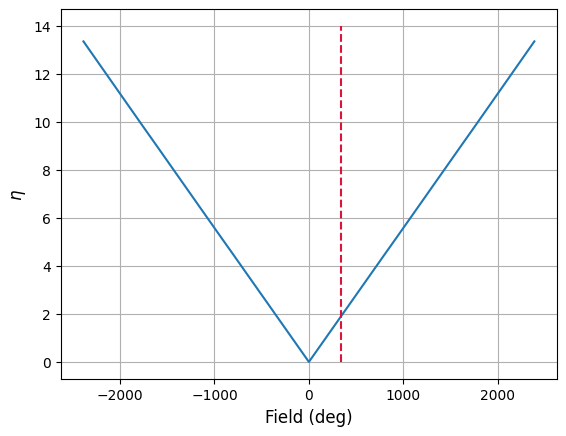

In [33]:
plt.plot(field_arr_px - int(ccd_width_px/2) + 1,rms_arr_px)
plt.vlines(338,0,14,ls='--',color='Crimson')
plt.ylabel(r'$\eta$',fontdict={'size':12})
plt.xlabel('Field (deg)',fontdict={'size':12})
plt.grid()

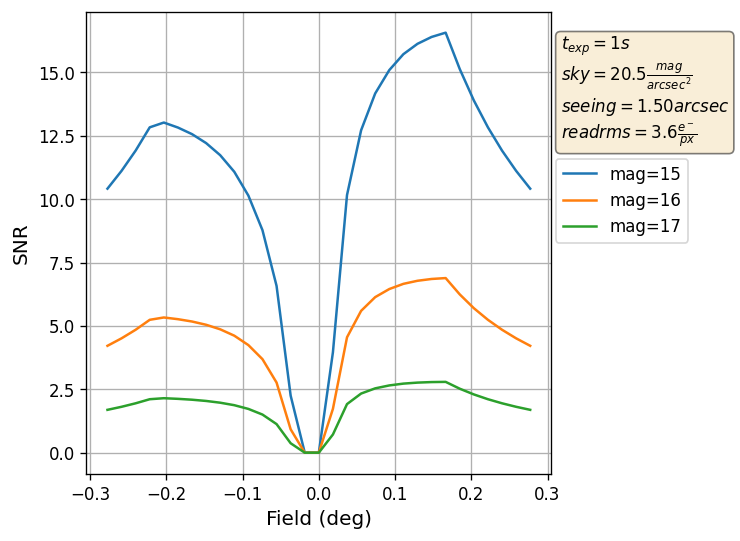

In [18]:
snr_vs_field(np.array([15,16,17]),3.6*u.electron)

In [24]:
table = create_table(max_mag_widget.value,ra_widget.value,dec_widget.value,True)
image = create_image(table,ra_widget.value,dec_widget.value,t_exp=1*u.s,mag_arcsec_squared=20.5,seeing_arcsec=1.5*u.arcsec,temp = -15)

In [14]:
np.save('output.npy',arr=image)